In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [3]:
def compute_curvature(p0, p1, p2):
    # p0, p1, p2 are (x, y) points
    x1, y1 = p0
    x2, y2 = p1
    x3, y3 = p2

    # Circle fitting curvature formula
    denom = (x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))
    if abs(denom) < 1e-6:
        return 0.0
    num = 2 * ((x1 - x2)*(y1 - y3) - (y1 - y2)*(x1 - x3))
    curvature = num / denom
    return curvature

In [4]:
def relative_distance(p1, p2):
        return math.hypot(p2[0] - p1[0], p2[1] - p1[1])

In [5]:
def simulate_agent(current_pos, waypoints, num_waypoints, speed_init, time_delta=0.1,
                   kp_speed=1, kp_steering=1, max_accel=4, max_steering=1, max_decel=4.0, max_speed=100):
    # Initial state
    sim_x = current_pos[0]
    sim_y = current_pos[1]
    sim_heading = current_pos[2]
    sim_vx = current_pos[3]
    sim_vy = current_pos[4]
    agent_length = 3.70019984
    headings = []
    vx = []
    vy = []
    speeds = []

    low_level_actions = [[0.0, 0.0] for _ in range(num_waypoints)]
    dreamed_waypoints = [[0.0, 0.0] for _ in range(num_waypoints)]

    def clip_value(val, lo, hi):
        return max(lo, min(val, hi))

    def relative_distance_2d(x1, y1, x2, y2):
        return math.hypot(x2 - x1, y2 - y1)

    def clip_speed(speed):
        return min(speed, max_speed)

    for i in range(num_waypoints):
        # Current simulated state
        sim_speed = math.sqrt(sim_vx ** 2 + sim_vy ** 2)
        speeds.append(sim_speed)

        # Target waypoint
        target_x, target_y = waypoints[i]

        # Compute target speed
        dist_to_target = relative_distance_2d(sim_x, sim_y, target_x, target_y)
        target_speed = dist_to_target / time_delta

        # Compute desired acceleration
        speed_error = target_speed - sim_speed
        desired_accel = (kp_speed * speed_error) / time_delta
        # desired_accel = 2.0

        # Compute desired steering
        dx = target_x - sim_x
        dy = target_y - sim_y
        desired_yaw = math.atan2(dy, dx)

        # Yaw error wrapped to [-pi, pi]
        yaw_error = desired_yaw - sim_heading
        yaw_error = math.atan2(math.sin(yaw_error), math.cos(yaw_error))

        # Proportional steering
        desired_steering = kp_steering * yaw_error


        # # Avoid going backwards if target is behind
        # forward_x = math.cos(sim_heading)
        # forward_y = math.sin(sim_heading)

        # dot = forward_x * dx + forward_y * dy

        # # Length of to-target vector
        # to_target_len = math.hypot(dx, dy)

        # # Cosine of angle between forward and target
        # cos_theta = dot / to_target_len

        # # If target is behind, override actions
        # if cos_theta < math.cos(math.radians(90)):
        #     desired_accel = -4
        #     desired_steering = 0
        # desired_steering *= (1 + 0.5 * (max_speed - sim_speed) / max_speed)

        # Clip to vehicle limits
        clipped_steering = clip_value(desired_steering, -max_steering, max_steering)
        # desired_accel *= max(1.0, 1.0 - abs(clipped_steering) / max_steering)
        clipped_accel = clip_value(desired_accel, -max_accel, max_accel)

        # Store the action
        low_level_actions[i][0] = clipped_accel
        low_level_actions[i][1] = clipped_steering

        # --- Simulate one step forward ---
        next_sim_speed = sim_speed + clipped_accel * time_delta
        if next_sim_speed < 0:
            next_sim_speed = 0
        next_sim_speed = clip_speed(next_sim_speed)

        beta = math.tanh(0.5 * math.tan(clipped_steering))
        yaw_rate = (next_sim_speed * math.cos(beta) * math.tan(clipped_steering)) / agent_length

        sim_vx = next_sim_speed * math.cos(sim_heading + beta)
        sim_vy = next_sim_speed * math.sin(sim_heading + beta)
        vy.append(sim_vy)
        vx.append(sim_vx)

        sim_x += sim_vx * time_delta
        sim_y += sim_vy * time_delta
        dreamed_waypoints[i][0] = sim_x
        dreamed_waypoints[i][1] = sim_y
        sim_heading += yaw_rate * time_delta
        headings.append(sim_heading)

    return low_level_actions, dreamed_waypoints, headings, vx, vy, speeds

In [6]:
def compute_controlled_trajectory_old(current_pos, waypoints, num_waypoints, time_delta=0.1,
                   kp_speed=1, kp_steering=1, max_accel=100, max_steering=100, max_decel=4.0, max_speed=100):
    # Initial state
    sim_x = current_pos[0]
    sim_y = current_pos[1]
    sim_heading = current_pos[2]
    sim_vx = current_pos[3]
    sim_vy = current_pos[4]
    agent_length = 3.70019984
    headings = []
    vx = []
    vy = []
    speeds = []

    low_level_actions = [[0.0, 0.0] for _ in range(num_waypoints)]
    dreamed_waypoints = [[0.0, 0.0] for _ in range(num_waypoints)]

    def clip_value(val, lo, hi):
        return max(lo, min(val, hi))

    def relative_distance_2d(x1, y1, x2, y2):
        return math.hypot(x2 - x1, y2 - y1)

    def clip_speed(speed):
        return min(speed, max_speed)

    for i in range(num_waypoints):
        # Current simulated state
        sim_speed = math.sqrt(sim_vx ** 2 + sim_vy ** 2)
        speeds.append(sim_speed)

        # Target waypoint
        target_x, target_y = waypoints[i, :2]

        # Compute target speed
        dist_to_target = relative_distance_2d(sim_x, sim_y, target_x, target_y)
        target_speed = dist_to_target / time_delta
        speed_error = target_speed - sim_speed
        desired_accel = (kp_speed * speed_error) / time_delta
        # desired_accel = 2.0

        # Compute desired steering
        dx = target_x - sim_x
        dy = target_y - sim_y
        desired_yaw = math.atan2(dy, dx)

        # Yaw error wrapped to [-pi, pi]
        yaw_error = desired_yaw - sim_heading
        yaw_error = math.atan2(math.sin(yaw_error), math.cos(yaw_error))

        # Proportional steering
        desired_steering = kp_steering * yaw_error

        # Clip to vehicle limits
        clipped_steering = clip_value(desired_steering, -max_steering, max_steering)
        # desired_accel *= max(1.0, 1.0 - abs(clipped_steering) / max_steering)
        clipped_accel = clip_value(desired_accel, -max_accel, max_accel)

        # Store the action
        low_level_actions[i][0] = clipped_accel
        low_level_actions[i][1] = clipped_steering

        # --- Simulate one step forward ---
        next_sim_speed = sim_speed + clipped_accel * time_delta
        if next_sim_speed < 0:
            next_sim_speed = 0
        next_sim_speed = clip_speed(next_sim_speed)

        beta = math.tanh(0.5 * math.tan(clipped_steering))
        yaw_rate = (next_sim_speed * math.cos(beta) * math.tan(clipped_steering)) / agent_length

        sim_vx = next_sim_speed * math.cos(sim_heading + beta)
        sim_vy = next_sim_speed * math.sin(sim_heading + beta)
        vy.append(sim_vy)
        vx.append(sim_vx)

        sim_x += sim_vx * time_delta
        sim_y += sim_vy * time_delta
        dreamed_waypoints[i][0] = sim_x
        dreamed_waypoints[i][1] = sim_y
        sim_heading += yaw_rate * time_delta
        headings.append(sim_heading)

    dreamed_waypoints = np.array(dreamed_waypoints)
    headings = np.array(headings)
    vx = np.array(vx)
    vy = np.array(vy)
    speeds = np.array(speeds)

    simulated_trajectory = np.column_stack((dreamed_waypoints, headings, vx, vy, speeds))

    # Columns: [x, y, heading, vx, vy, speed]
    return np.array(low_level_actions), simulated_trajectory

In [7]:
def compute_controlled_trajectory(current_pos, waypoints, num_waypoints, time_delta=0.1,
                                  max_accel=4, max_steering=1, max_speed=100):
    # Initial state
    sim_x = current_pos[0]
    sim_y = current_pos[1]
    sim_heading = current_pos[2]
    sim_vx = current_pos[3]
    sim_vy = current_pos[4]
    agent_length = 3.70019984
    headings = []
    vx = []
    vy = []
    speeds = []

    low_level_actions = [[0.0, 0.0] for _ in range(num_waypoints)]
    dreamed_waypoints = [[0.0, 0.0] for _ in range(num_waypoints)]

    def clip_value(val, lo, hi):
        return max(lo, min(val, hi))

    def relative_distance_2d(x1, y1, x2, y2):
        return math.hypot(x2 - x1, y2 - y1)

    def clip_speed(speed):
        return min(speed, max_speed)

    for i in range(num_waypoints):
        # Current simulated state
        sim_speed = math.sqrt(sim_vx ** 2 + sim_vy ** 2)
        speeds.append(sim_speed)

        target_x, target_y = waypoints[i, :2]
        # Compute desired accel
        v0 = sim_speed
        v1 = waypoints[i, 6]
        v_avg = (v0 + v1) / 2
        desired_accel = (v1 - v0) / time_delta

        # Compute desired steering
        theta0 = sim_heading
        theta1 = waypoints[i, 2]
        desired_yaw_rate = (theta1 - theta0) / time_delta
        desired_steering = math.atan(desired_yaw_rate * agent_length  / v_avg)

        # Clip to vehicle limits
        clipped_steering = clip_value(desired_steering, -max_steering, max_steering)
        clipped_accel = clip_value(desired_accel, -max_accel, max_accel)


        # # Avoid going backwards if target is behind
        forward_x = math.cos(sim_heading)
        forward_y = math.sin(sim_heading)

        dx = target_x - sim_x
        dy = target_y - sim_y

        dot = forward_x * dx + forward_y * dy

        # Length of to-target vector
        to_target_len = math.hypot(dx, dy)

        # Cosine of angle between forward and target
        cos_theta = dot / to_target_len

        # If target is behind, override actions
        if cos_theta < math.cos(math.radians(45)):
            clipped_accel = -4
            clipped_steering = 0


        # Store the action
        low_level_actions[i][0] = clipped_accel
        low_level_actions[i][1] = clipped_steering

        # --- Simulate one step forward ---
        next_sim_speed = sim_speed + clipped_accel * time_delta
        if next_sim_speed < 0:
            next_sim_speed = 0
        # next_sim_speed = clip_speed(next_sim_speed)

        v_avg_real = (next_sim_speed + sim_speed) / 2

        beta = 0 #  math.tanh(0.5 * math.tan(clipped_steering))
        yaw_rate = (v_avg_real * math.cos(beta) * math.tan(clipped_steering)) / agent_length
        new_heading = sim_heading + yaw_rate * time_delta
        theta_avg_real = (new_heading + sim_heading) / 2

        sim_vx = v_avg_real * math.cos(theta_avg_real + beta)
        sim_vy = v_avg_real * math.sin(theta_avg_real + beta)
        vy.append(sim_vy)
        vx.append(sim_vx)

        sim_x += sim_vx * time_delta
        sim_y += sim_vy * time_delta
        dreamed_waypoints[i][0] = sim_x
        dreamed_waypoints[i][1] = sim_y
        sim_heading = new_heading
        headings.append(sim_heading)

    dreamed_waypoints = np.array(dreamed_waypoints)
    headings = np.array(headings)
    vx = np.array(vx)
    vy = np.array(vy)
    speeds = np.array(speeds)

    simulated_trajectory = np.column_stack((dreamed_waypoints, headings, vx, vy, speeds))

    # Columns: [x, y, heading, vx, vy, speed]
    return np.array(low_level_actions), simulated_trajectory

In [8]:
def build_trajectories_from_params(t_values, coeffs_longi, coeffs_lat):
    x = np.polyval(coeffs_longi, t_values)
    y = np.polyval(coeffs_lat, t_values)

    # Derivatives (velocity)
    coeffs_longi_d = np.polyder(coeffs_longi)
    coeffs_lat_d = np.polyder(coeffs_lat)
    vx = np.polyval(coeffs_longi_d, t_values)
    vy = np.polyval(coeffs_lat_d, t_values)

    # Second derivatives (acceleration)
    coeffs_longi_dd = np.polyder(coeffs_longi_d)
    coeffs_lat_dd = np.polyder(coeffs_lat_d)
    ax = np.polyval(coeffs_longi_dd, t_values)
    ay = np.polyval(coeffs_lat_dd, t_values)

    # Heading (orientation)
    headings = np.arctan2(vy, vx)

    # Speed (magnitude of velocity)
    speed = np.sqrt(vx**2 + vy**2)

    # Curvature (kappa)
    curvature = (vx * ay - vy * ax) / np.power(vx**2 + vy**2, 1.5)

    # Stack all results
    local_wps = np.column_stack((x, y, headings, vx, vy, curvature, speed))
    print(coeffs_longi_d)
    print(coeffs_lat_d)
    print(coeffs_longi_dd)
    print(coeffs_lat_dd)
    return local_wps

In [9]:
def from_local_to_global(local_waypoints, current_x, current_y, current_heading):
    """
    Transforms local waypoints [x, y, heading, vx, vy, curvature, speed]
    into global coordinates.
    """
    cos_h = np.cos(current_heading)
    sin_h = np.sin(current_heading)
    R = np.array([[cos_h, -sin_h],
                  [sin_h,  cos_h]])

    # 1. Position: rotate + translate
    global_xy = (R @ local_waypoints[:, :2].T).T + np.array([current_x, current_y])

    # 2. Velocity: rotate only
    global_v = (R @ local_waypoints[:, 3:5].T).T

    # 3. Heading: add global offset
    global_heading = local_waypoints[:, 2] + current_heading
    # global_heading = (local_waypoints[:, 2] + current_heading + np.pi) % (2 * np.pi) - np.pi

    # 4. Curvature and speed: unchanged
    curvature = local_waypoints[:, 5]
    speed = local_waypoints[:, 6]

    # Stack everything together
    global_waypoints = np.column_stack((global_xy, global_heading, global_v, curvature, speed))
    return global_waypoints

[0.         0.         0.         4.         5.79008198]
[0.         0.         0.         4.16133022 0.        ]
[0. 0. 0. 4.]
[0.         0.         0.         4.16133022]


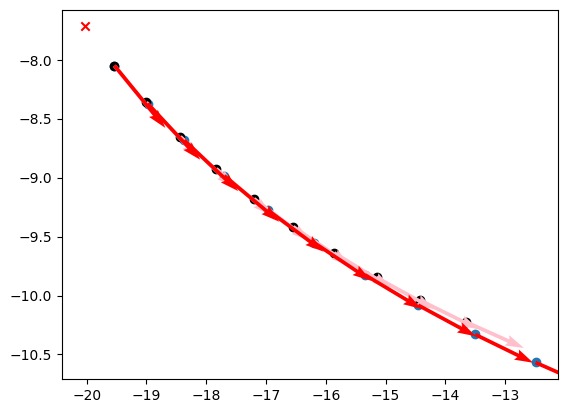

[7.81922546e-05 1.17016994e-03 2.00837580e-03 2.63211440e-03
 3.08227875e-03 3.39534451e-03 3.60189127e-03 3.72667008e-03
 3.78929433e-03 3.80510336e-03]
[-0.29077185 -0.48823036 -0.71810885 -0.97252599 -1.24675179 -1.53696542
 -1.84011421 -2.15377107 -2.4760077  -2.80528918]
[[4.         0.39265409]
 [4.         0.33057626]
 [4.         0.28325535]
 [4.         0.2431823 ]
 [4.         0.20944952]
 [4.         0.18111685]
 [4.         0.15730957]
 [4.         0.1372613 ]
 [4.         0.120323  ]
 [4.         0.10595552]]


In [17]:
max_speed = 100.0 #50.0
num_waypoints = 10
t_values = np.linspace(0, num_waypoints/10, num_waypoints + 1)
veh_speed = 5.79008198
current_pos = -20.0344238, -7.71844482, -0.622170269, 4.69884634, -3.38317776  # x, y, heading, vx, vy

for _ in range(1):
    coeffs_longi = [random.uniform(1, 1) for _ in range(6)]
    coeffs_longi[0] = 0 # c5
    coeffs_longi[1] = 0 # c4
    coeffs_longi[2] = 0 # c3
    coeffs_longi[3] = 2 # c2
    coeffs_longi[4] = veh_speed # c1
    coeffs_longi[5] = 0 # c0

    coeffs_lat = [random.uniform(-1, 1) for _ in range(6)]
    coeffs_lat[0] = 0 # c5
    coeffs_lat[1] = 0 # c4
    coeffs_lat[2] = 0 # c3
    coeffs_lat[3] = 2.08066511 # c2
    coeffs_lat[4] = 0 # c1
    coeffs_lat[5] = 0 # c0


    # Build trajectories (x, y, heading, vx, vy, curvature, speeds)
    local_waypoints = build_trajectories_from_params(t_values, coeffs_longi, coeffs_lat)
    current_x, current_y, current_heading, _, _ = current_pos  # assuming [x, y, yaw]

    # Rotation matrix (2x2)
    global_waypoints = from_local_to_global(local_waypoints, current_x, current_y, current_heading)


    # Control actions from trajectory
#     control_actions, simulated_trajectory = compute_controlled_trajectory(current_pos, global_waypoints[1:],
#                                                                           num_waypoints=len(t_values)-1)
    control_actions, simulated_trajectory = compute_controlled_trajectory(current_pos, global_waypoints[1:],
                                                                          num_waypoints=len(t_values)-1)

    ##### Plot
    plt.scatter(global_waypoints[1:, 0], global_waypoints[1:, 1],
                label=f"longi={np.round(coeffs_longi,2)}\nlat={np.round(coeffs_lat,2)}")

    plt.scatter(simulated_trajectory[:, 0], simulated_trajectory[:, 1], c='black', marker='o')
    plt.plot([], [], ' ', label=f"controls={np.round(control_actions,2)}")
    # Angles plot
    dx_controlled = np.cos(simulated_trajectory[:, 2])
    dy_controlled = np.sin(simulated_trajectory[:, 2])
    plt.quiver(simulated_trajectory[:, 0], simulated_trajectory[:, 1],
               dx_controlled, dy_controlled, angles='xy', scale_units='xy', scale=1.0, color='pink')

    pred_headings = global_waypoints[1:, 2] # np.array(pred_headings)
    dx_pred = np.cos(pred_headings)
    dy_pred = np.sin(pred_headings)
    plt.quiver(global_waypoints[1:, 0], global_waypoints[1:, 1],
            dx_pred, dy_pred, angles='xy', scale_units='xy', scale=1.0, color='red')

    plt.scatter(current_pos[0], current_pos[1], c='red', marker='x')
    plt.show()

    print(pred_headings - simulated_trajectory[:, 2])
    print(simulated_trajectory[:, 3] - global_waypoints[1:, 3])
    print(control_actions)

In [19]:
global_waypoints[1:, :2]

array([[-19.53553431,  -8.05063907],
       [-18.97988796,  -8.3723297 ],
       [-18.36748476,  -8.68351672],
       [-17.69832469,  -8.98420014],
       [-16.97240777,  -9.27437994],
       [-16.18973398,  -9.55405613],
       [-15.35030334,  -9.82322871],
       [-14.45411583, -10.08189768],
       [-13.50117147, -10.33006303],
       [-12.49147025, -10.56772478]])

In [20]:
global_waypoints[1:, 2] # headings

array([-0.5550455 , -0.49654464, -0.44543782, -0.40062869, -0.36117124,
       -0.32626413, -0.29523514, -0.2675229 , -0.24265906, -0.22025244])

In [ ]:
global_waypoints[1:, 3] # vx

array([ 5.27267918,  5.84024777,  6.40781636,  6.97538496,  7.54295355,
        8.11052214,  8.67809074,  9.24565933,  9.81322792, 10.38079652])

In [ ]:
global_waypoints[1:, 4] # vy

array([-3.2694244 , -3.16438829, -3.05935218, -2.95431607, -2.84927996,
       -2.74424385, -2.63920774, -2.53417163, -2.42913552, -2.32409941])

In [24]:
global_waypoints[1:, 5] # curvature

array([0.10089979, 0.08221222, 0.06730013, 0.05542822, 0.04596223,
       0.0383848 , 0.03228625, 0.02734724, 0.0233206 , 0.02001538])

In [25]:
global_waypoints[1:, 6] # curvature

array([ 6.20405364,  6.64242781,  7.10068633,  7.57522137,  8.06315971,
        8.56221021,  9.07053892,  9.58667003, 10.10940857, 10.63778052])

In [ ]:
global_waypoints

In [ ]:
dreamed_waypoints

In [ ]:
num_waypoints = 10
t_values = np.linspace(0, 1, num_waypoints + 1)
t_values

In [ ]:
local_waypoints

In [ ]:
dreamed_waypoints

### SIMULATE RL ENV CONTROL AND TRAJ

In [ ]:
def simulate_agent_control(current_pos, waypoints, num_waypoints, speed_init, time_delta=0.1,
                   kp_speed=1, kp_steering=1, max_accel=4, max_steering=1, max_speed=100):
    """
    Simulates low-level control actions for an agent following waypoints.

    Parameters:
        env: object containing entities
        agent_idx: index of the agent in env.entities
        waypoints: list of [x, y] targets
        num_waypoints: number of waypoints to simulate
        time_delta: timestep for simulation
        kp_speed: proportional gain for speed control
        kp_steering: proportional gain for steering control
        max_accel: maximum allowed acceleration
        max_steering: maximum allowed steering angle
        max_speed: maximum allowed speed
    """
    # Initial state
    sim_x = current_pos[0]
    sim_y = current_pos[1]
    sim_heading = current_pos[2]
    sim_vx = current_pos[3]
    sim_vy = current_pos[4]
    agent_length = 3.5

    low_level_actions = [[0.0, 0.0] for _ in range(num_waypoints)]
    dreamed_waypoints = [[0.0, 0.0] for _ in range(num_waypoints)]


    def clip_value(val, lo, hi):
        return max(lo, min(val, hi))

    def relative_distance_2d(x1, y1, x2, y2):
        return math.hypot(x2 - x1, y2 - y1)

    def clip_speed(speed):
        return min(speed, max_speed)

    for i in range(num_waypoints):
        # Current simulated state
        sim_speed = math.sqrt(sim_vx ** 2 + sim_vy ** 2)

        target_x = waypoints[i][0]
        target_y = waypoints[i][1]

        # Compute target speed
        dist_to_target = relative_distance_2d(sim_x, sim_y, target_x, target_y)
        target_speed = dist_to_target / time_delta

        # Compute desired acceleration
        speed_error = target_speed - sim_speed
        desired_accel = (kp_speed * speed_error) / time_delta
        # desired_accel = 2.0

        # Compute desired steering
        # dx = target_x - sim_x
        # dy = target_y - sim_y
        # desired_yaw = math.atan2(dy, dx)
        if i != num_waypoints - 1:
            target_xp = waypoints[i + 1][0]
            target_yp = waypoints[i + 1][1]
            dxp = target_xp - target_x
            dyp = target_yp - target_y
            desired_yaw = math.atan2(dyp, dxp)
        else:
            dx = target_x - sim_x
            dy = target_y - sim_y
            desired_yaw = math.atan2(dy, dx)

        # Yaw error wrapped to [-pi, pi]
        yaw_error = desired_yaw - sim_heading
        yaw_error = math.atan2(math.sin(yaw_error), math.cos(yaw_error))

        # Proportional steering
        desired_steering = kp_steering * yaw_error

        # Clip to vehicle limits
        clipped_accel = clip_value(desired_accel, -max_accel, max_accel)
        clipped_steering = clip_value(desired_steering, -max_steering, max_steering)

        # Store the action
        low_level_actions[i][0] = clipped_accel
        low_level_actions[i][1] = clipped_steering

        # --- Simulate one step forward ---
        next_sim_speed = sim_speed + clipped_accel * time_delta
        if next_sim_speed < 0:
            next_sim_speed = 0
        next_sim_speed = clip_speed(next_sim_speed)

        beta = math.tanh(0.5 * math.tan(clipped_steering))
        yaw_rate = (next_sim_speed * math.cos(beta) * math.tan(clipped_steering)) / agent_length

        sim_vx = next_sim_speed * math.cos(sim_heading + beta)
        sim_vy = next_sim_speed * math.sin(sim_heading + beta)

        sim_x += sim_vx * time_delta
        sim_y += sim_vy * time_delta
        dreamed_waypoints[i][0] = sim_x
        dreamed_waypoints[i][1] = sim_y
        sim_heading += yaw_rate * time_delta

        if i == 0:
            next_pos = sim_x, sim_y, sim_heading, sim_vx, sim_vy

    return low_level_actions, dreamed_waypoints, next_pos

In [ ]:
# Temporal succession of control and steps
num_waypoints = 10
t_values = np.linspace(0, num_waypoints/10, num_waypoints + 1)
USE_LOOKAHEAD = False

controlled_waypoints = []
pred_trajectories = []
veh_speed = 26.1263924
current_pos = 73.2060547, -206.453125, 1.82876945, -6.6878562, 25.255909  # x, y, heading, vx, vy
chosen_actions = []
# Simulate 5 actions with same trajectory predicted
headings = []
headings.append(current_pos[2])
for i in range(10):

    coeffs_longi = [random.uniform(-1, 1) for _ in range(3)]
    coeffs_longi[0] = 0.0 # c2
    coeffs_longi[1] = veh_speed # c1
    coeffs_longi[2] = 0 # c0


    coeffs_lat = [random.uniform(-1, 1) for _ in range(3)]
    coeffs_lat[0] = 5.0 # c2 10
    coeffs_lat[1] = 2.0 # c1 3
    coeffs_lat[2] *= 0 # c0

    # max_longi_acc = 3 - 1 * abs(coeffs_lat[1])
    # coeffs_longi[1] = np.clip(coeffs_longi[1], -max_longi_acc, max_longi_acc)

    # Evaluate polynomials
    longi_traj = np.polyval(coeffs_longi, t_values)
    lateral_traj = np.polyval(coeffs_lat, t_values)

    # Stack waypoints
    # Extract vehicle position and heading
    current_x, current_y, current_heading, _, _ = current_pos  # assuming [x, y, yaw]
    local_waypoints = np.stack([longi_traj, lateral_traj], axis=-1)
    local_waypoints = local_waypoints[1:] # + np.array([current_x, current_y])
    # pred_trajectories.append(local_waypoints)

    # Rotation matrix (2x2)
    cos_h = np.cos(current_heading)
    sin_h = np.sin(current_heading)
    R = np.array([[cos_h, -sin_h],
                [sin_h,  cos_h]])

    # Apply transform: rotate then translate
    global_waypoints = (R @ local_waypoints.T).T + np.array([current_x, current_y])

    # Store trajectory in global frame
    pred_trajectories.append(global_waypoints)

    control_actions, dreamed_waypoints, current_pos = simulate_agent_control(current_pos, global_waypoints, kp_steering=1.0,
                                                                             num_waypoints=len(t_values)-1, speed_init=veh_speed)

    controlled_waypoints.append(dreamed_waypoints[0])
    chosen_actions.append(control_actions[0])
    headings.append(current_pos[2])


colors = plt.cm.tab10(np.linspace(0, 1, 5))  # 5 distinct colors from the "tab10" colormap
print(chosen_actions)
for i in range(5):
    plt.scatter(pred_trajectories[i][:, 0], pred_trajectories[i][:, 1],
                color=colors[i], marker='x', s=25)
    # plt.text(pred_trajectories[i][:, 0][9], pred_trajectories[i][:, 1][9], str(i), fontsize=10, color='red')


controlled_waypoints = np.array(controlled_waypoints)
controlled_waypoints = np.vstack(([0, 0], controlled_waypoints))

plt.scatter(controlled_waypoints[:, 0], controlled_waypoints[:, 1], c='black', marker='o', s=15.0)

# Plot headings as arrows (unit vectors from angle in radians)
headings = np.array(headings)  # assuming same length as controlled_waypoints
dx = np.cos(headings)
dy = np.sin(headings)

plt.quiver(controlled_waypoints[:, 0], controlled_waypoints[:, 1],
           dx, dy, angles='xy', scale_units='xy', scale=0.6, color='pink')
# print(control_actions)
# --- Keep (0,0) at the center ---
max_range = np.max(np.abs(local_waypoints))
plt.xlim(-5, 50)
plt.ylim(-5, 20)
plt.gca().set_aspect('equal', adjustable='box')
# plt.axis("equal")
plt.scatter(0, 0, c='red', marker='x')
plt.legend(fontsize=8, loc="best")
plt.show()